
# Proyección matemática evolución epidemia en España.

Antes de empezar, quede claro que se trata de un mero ejercicio intelectual y que, en ningún caso tiene la pretención de ser un trabajo riguroso de modelización matemática.

Una epidemia que evoluciona de forma natural, acostumbra a dibujar una curva de tipo **sigmoide**, como la que representaremos a continución. Al principio crece lentamente, para crecer cada vez de forma más rápida, a medida que aumentan el número de indivíduos contagiosos, para finalmente ir disminuyendo el ritmo de contagio a medida que la población adquiere inmunidad, hasta llegar a cero (en el mejor de los casos).


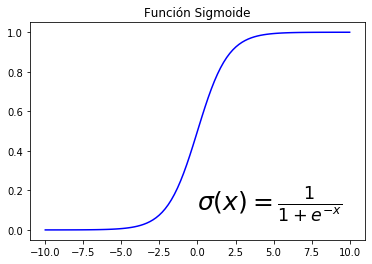

In [2]:
import numpy as np
import matplotlib.pyplot as plt

sigmoide = lambda x: 1 / (1 + np.exp(-x))
y = np.linspace(-10,10,100)
plt.plot(y, sigmoide(y), 'b')
plt.title('Función Sigmoide')

plt.text(0, 0.1, r'$\sigma(x)=\frac{1}{1+e^{-x}}$', fontsize=25)
plt.show()

El ejemplo anterior representa la curva sigmoide más simple, pero la podemos complicar de la siguiente manera
# $f(x, a, b, c) = \frac{c}{1+e^{-(x - b) / a}}$

Donde:
 * $a$ es la velocidad de contagio.
 * $b$ es el día con el máximo número de infecciones (punto de inflexión de la curva).
 * $c$ es el número total de infectados (la cima de la curva).
 * $x$ es el número de días desde el inicio.

En teoría, conociendo la evolución del número de infectados reales, pasado cierto número de días, podemos intentar deducir los valores de la fórmula, en base al aspecto del inicio de la curva. Está claro que esto sería una extrapolción que tendría un cierto parecido con la realidad pero, además, tenemos la dificultad añadida de que se desconoce cual a sido la evolución real de los infectados. Muchos ni siquiera han acudido al médico, por presentar síntomas muy leves, o imcluso ser asintomáticos.

La única información de la que disponemos es el número oficial de casos detectados que, con un poco de suerte, tendrá una distribución similar al de número de casos reales.

Lo primero que podemos hacer es comprobar si en China, que parece haber controlado la epidemia, 
la evolución realmente se ha comportado siguiendo una curva sigmoide.

## Comparativa China y UE.

[]

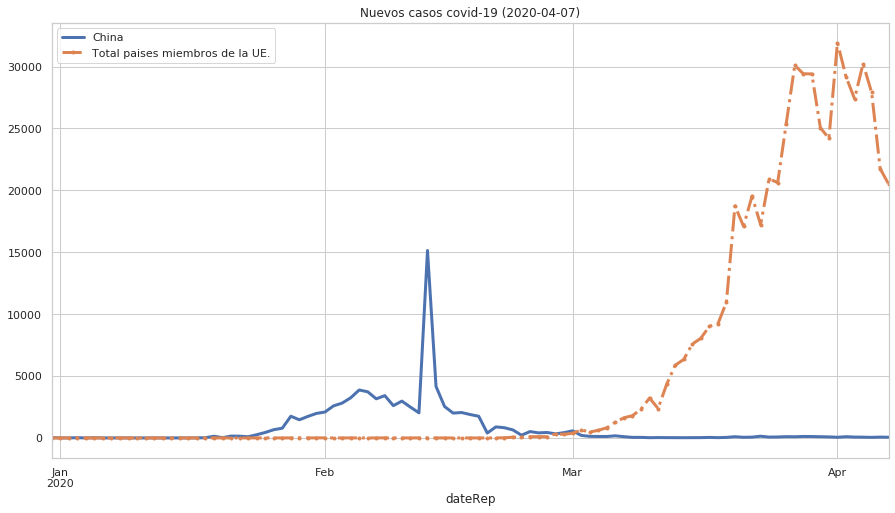

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import sys

# Configuración visualización
%matplotlib inline
sns.set()
sns.set(style='whitegrid')

plt.clf()
plt.cla()
plt.close()

fecha   = datetime.date.today()
undia   = datetime.timedelta(days=1)
fichero = fecha.strftime("%Y-%m-%d") 
extension = "xlsx"

# Cargamos datos del Centro Europeo de Prevención de Enfermedades
while True:
    try:
        df = pd.read_excel(f"https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{fichero}.{extension}",
                parse_dates=['dateRep'], 
                dayfirst=True,
                index_col='dateRep'            
        )
        break
    except:
        if extension == "xlsx":
            extension = "xls"
        else:
            extension = "xlsx"
            fecha = (fecha - undia)
            fichero = fecha.strftime("%Y-%m-%d") 
        pass

df.sort_index(inplace=True)

EU = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
    'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy',
    'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal',
    'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
]

# Representamos los nuevos casos, China y EU
df[(df['countriesAndTerritories'] == 'China')]['cases'].plot(figsize=(15, 8), lw=3, legend=True, label='China')
df[(df['countriesAndTerritories'].isin(EU))]['cases'].groupby(['dateRep']).sum().plot(style='.-.', title=f'Nuevos casos covid-19 ({fichero})', lw=3, legend=True, label='Total paises miembros de la UE.')

plt.legend()
plt.plot()

Del gráfico anterior llama la atención un par de cosas:
 * La gran diferencia entre el número de casos diarios que existe entre la evolución de los contagios en China y en la UE.
 * El gran pico que se produce en el caso se China y que rompe la *distribución normal*.
 
Es por esto que hay quien pone en duda que los datos dados a conocer por China sean realmente los reales. Pero como son los únicos de los que disponemos, vamos a intentar comprobar si se ajusta a una curva sigmoide y si una estimación con los datos iniciales se habría ajustado a la evolución real final.

[]

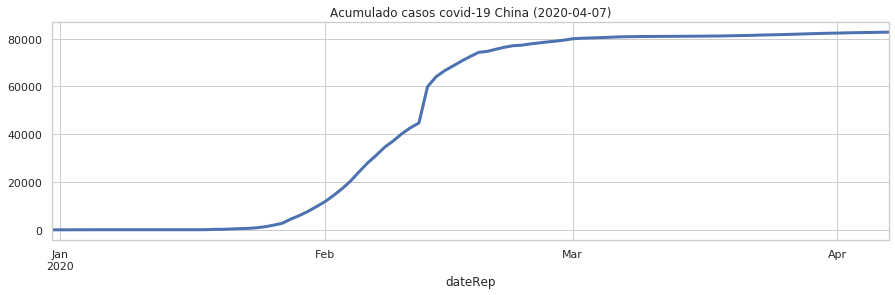

In [4]:
df[(df['countriesAndTerritories'] == 'China')]['cases'].cumsum().plot(figsize=(15, 4), title=f'Acumulado casos covid-19 China ({fichero})', lw=3, legend=False)
plt.plot()

En el gráfico superior podemos observar que sí que tiene cierto precido con una curva sigmoide, por lo que vamos a comprobar que tan exacta habría sido una predicción basada en una estimación de los coeficientes en funcion de un número de valores registrados desde el inico de la epidemia.

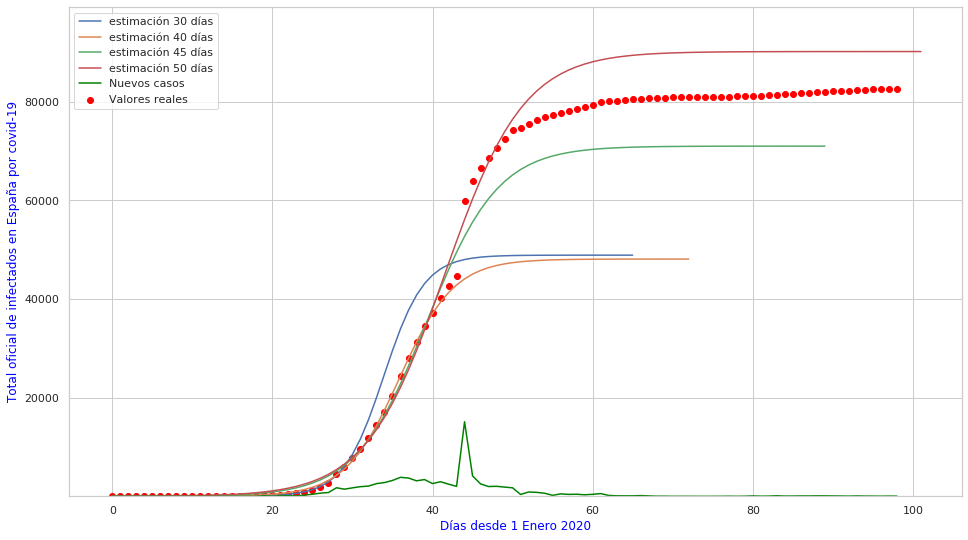

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta,date
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

df_casos = df.loc[(df['countriesAndTerritories'] == 'China'), ['cases']]

# convertimos las fechas en días desde el inicio y posteriormente vamos calculando valores acumulados.
FMT = "%d/%m/%Y"
date = df_casos.index
df_casos['days'] = date.map(lambda x : (x - datetime.strptime("31/12/2019", FMT)).days)
df_casos['acumulate'] = df_casos['cases'].cumsum()

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

nd = list(df_casos.iloc[:,0])

plt.rcParams['figure.figsize'] = [16, 9]
plt.rc('font', size=14)

for periodo in [30, 40, 45, 50]:
    x = list(df_casos.iloc[:periodo,1])
    y = list(df_casos.iloc[:periodo,2])
    fit = curve_fit(logistic_model,x,y)
    a = fit[0][0]
    b = fit[0][1]
    c = fit[0][2]
    sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    pred_x = list(range(max(x),sol))
    plt.plot(x + pred_x, [logistic_model(i, a, b, c) for i in x + pred_x], label=f"estimación {periodo} días")

# Datos reales
x = list(df_casos.iloc[:,1])
y = list(df_casos.iloc[:,2])

plt.scatter(x,y,label="Valores reales",color="red")
plt.plot(x, nd, label="Nuevos casos", color='green')
plt.legend()
plt.xlabel("Días desde 1 Enero 2020", color="blue")
plt.ylabel("Total oficial de infectados en España por covid-19", color="blue")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()

Como podemos observar en el gráfico, la evolución real se encuentra entre las estimaciones hechas con los datos de los primeros 45 y 50 días. Aunque en ningún caso se ajusta completamente a la evolución del número de casos, aunque si que habría permitido anticipar que, a partir del día 60, el crecimiento iba a ser casi nulo.

Pero como hemos comentado antes, no parece que la distribución de nuevos casos se corresponda a una distribución natural, por lo que vamos a ver como se comportan los datos de España.

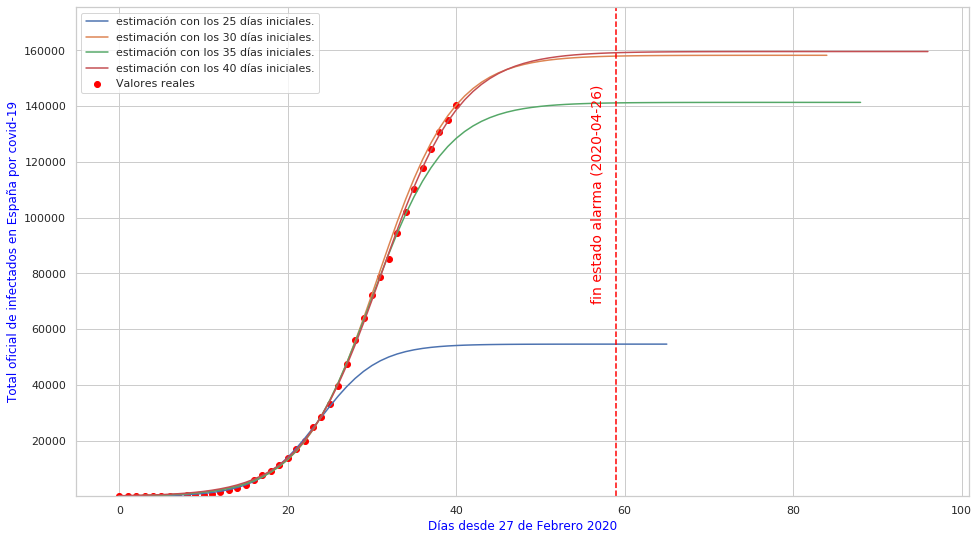

In [6]:
url_casos = "https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019/ccaa_covid19_casos.csv"
df_casos = pd.read_csv(url_casos, index_col='CCAA')     
del df_casos['cod_ine']

FMT = "%Y-%m-%d"
df_casos = df_casos.T
df_casos.reset_index() 
date = df_casos.index
df_casos['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-02-27", FMT)).days)

df_casos_T = df_casos[['date', 'Total',]].copy()

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

plt.rcParams['figure.figsize'] = [16, 9]
plt.rc('font', size=14)

max_dias = max(df_casos_T['date'])
for periodo in [25, 30, 35, max_dias]:
    x = list(df_casos_T.iloc[:periodo,0])
    y = list(df_casos_T.iloc[:periodo,1])
    fit = curve_fit(logistic_model,x,y,p0=[1,0,1], maxfev=5000)
    a = fit[0][0]
    b = fit[0][1]
    c = fit[0][2]
    sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    pred_x = list(range(max(x),sol))
    plt.plot(x + pred_x, [logistic_model(i, a, b, c) for i in x + pred_x], label=f"estimación con los {periodo} días iniciales.")

# Datos reales
x = list(df_casos_T.iloc[:,0])
y = list(df_casos_T.iloc[:,1])

plt.scatter(x,y,label="Valores reales",color="red")

plt.legend()
plt.xlabel("Días desde 27 de Febrero 2020", color="blue")
plt.ylabel("Total oficial de infectados en España por covid-19", color="blue")
plt.ylim((min(y)*0.9,c*1.1))

# Fin cuarentena
FC = "2020-04-26"
marca_FC = (datetime.strptime(FC, FMT) - datetime.strptime("2020-02-27", FMT)).days
plt.axvline(x=marca_FC, color='red',ls='--')

plt.text(marca_FC - 3, max(y) / 2, f'fin estado alarma ({FC})', rotation=90, color='red')
plt.show()

Podemos observar que la estimación con los datos del día 30, es plenamente coincidente con los datos reales hasta el momento, y con la estimación a partir de la última realidad conocida. Esto invita a pensar que igual se trata de un modelo con visos de fiabilidad. Si esto fuera así, durante esta semana entraremos en una fase de descenso noable del ritmo de contagios y, para el día de levantamiento de la cuarentena, la tasa será cercana a cero.

Claro está que, todavía queda por ver el impacto que tendrá el levantamiento del cese total de toda actividad no esencial que se producurá la próxima semana pero, sobre todo, el que se producirá tras la finalización del estado de alarma.